/tmp/ipykernel_189761/248979281.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Experiment name", y="Individual gain", data=df_melted, palette=palette,


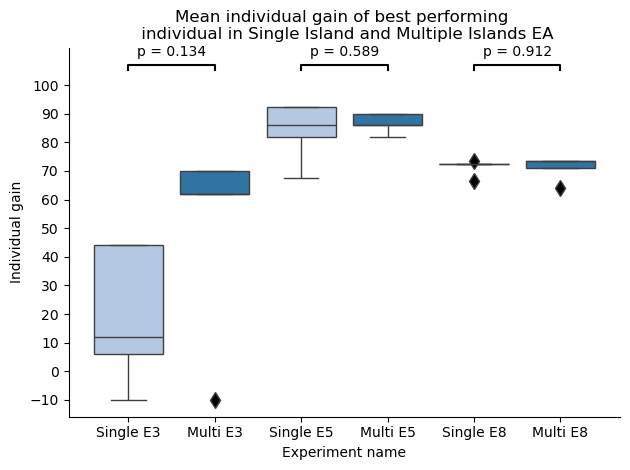

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 原始数据
data = {
    "EA": [2, 1, 2, 1, 2, 1],
    "enemy": [3, 3, 5, 5, 8, 8],
    "r1": [-10.0, 44, 86.2, 92.2, 73.6, 73.6],
    "r2": [70, 44, 89.8, 86.2, 71.2, 72.4],
    "r3": [70, -10, 86.2, 82.0, 73.6, 66.4],
    "r4": [62, 6, 82.0, 67.6, 63.9, 72.4],
    "r5": [62, 12, 89.8, 92.2, 73.6, 72.4]
}
df = pd.DataFrame(data)

# 交换奇数行和偶数行
df.iloc[::2], df.iloc[1::2] = df.iloc[1::2].values, df.iloc[::2].values

# 将 DataFrame 转换为适合 seaborn 的长格式
df_melted = df.melt(id_vars=["EA", "enemy"], value_vars=["r1", "r2", "r3", "r4", "r5"], 
                    var_name="round", value_name="Individual gain")

# 创建实验名称列以匹配之前的箱线图格式
df_melted["Experiment name"] = df_melted.apply(lambda row: f"Multi E{row['enemy']}" if row['EA'] == 2 else f"Single E{row['enemy']}", axis=1)

# Define color palette for odd and even experiments
palette = {
    "Multi E8": "#1f77b4",  # Darker blue for odd columns (Mig)
    "Single E8": "#aec7e8",  # Lighter blue for even columns (No Mig)
    "Multi E5": "#1f77b4",
    "Single E5": "#aec7e8",
    "Multi E3": "#1f77b4",
    "Single E3": "#aec7e8"
}

sns.boxplot(x="Experiment name", y="Individual gain", data=df_melted, palette=palette, 
            flierprops=dict(marker='d', color='black', markerfacecolor='black', markersize=8))

# Set plot labels and title
plt.title("Mean individual gain of best performing \n individual in Single Island and Multiple Islands EA")
plt.xlabel("Experiment name")
plt.ylabel("Individual gain")
# Set y-axis tick spacing to 10
plt.yticks(range(int(df_melted["Individual gain"].min()) - 10, int(df_melted["Individual gain"].max()) + 10, 10))
# Show the plot with horizontal x-axis labels
plt.xticks(rotation=0)
# Remove top and right spines
sns.despine()
plt.tight_layout()

from scipy.stats import ttest_ind
# Create a list to store p-values for each pair with the same 'enemy'
p_values = []
# Add p-values to the plot for each enemy group
enemy_labels = df["enemy"].unique()
experiment_names = df_melted["Experiment name"].unique()
# Group data by 'enemy' and calculate p-values for Mig vs No Mig for each group
for enemy in df["enemy"].unique():
    mig_data = df_melted[(df_melted["enemy"] == enemy) & (df_melted["EA"] == 2)]["Individual gain"]
    no_mig_data = df_melted[(df_melted["enemy"] == enemy) & (df_melted["EA"] == 1)]["Individual gain"]
    
    # Perform t-test to calculate p-value
    t_stat, p_value = ttest_ind(mig_data, no_mig_data, equal_var=False)
    p_values.append((enemy, p_value))
# Set a consistent y-value for all p-value annotations
y_max = df_melted["Individual gain"].max() + 15

# Add p-values to the plot for each enemy group
for enemy, p_value in p_values:
    # Find the positions of the groups to compare
    mig_label = f"Multi E{enemy}"
    no_mig_label = f"Single E{enemy}"
    
    mig_pos = list(experiment_names).index(mig_label)
    no_mig_pos = list(experiment_names).index(no_mig_label)
    
    # Draw a line between the two groups and annotate with the p-value
    plt.plot([mig_pos, mig_pos, no_mig_pos, no_mig_pos], [y_max - 2, y_max, y_max, y_max - 2], color='black', lw=1.5)
    plt.text((mig_pos + no_mig_pos) / 2, y_max + 2, f"p = {p_value:.3f}", ha='center', va='bottom')

# Show the plot with horizontal x-axis labels
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
plt.show()


In [39]:
import pandas as pd
import os


def process_fitness_files(folder_path):
    best_fitness_list = []
    mean_fitness_list = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            # Read the file, ignoring the first line
            data = pd.read_csv(file_path, sep="\s+", skiprows=1)
            best_fitness_list.append(data["best"])
            mean_fitness_list.append(data["mean"])

    if not best_fitness_list or not mean_fitness_list:
        raise ValueError("No valid data found in the provided folder path.")

    # Concatenate the lists into DataFrames
    best_fitness_df = pd.concat(best_fitness_list, axis=1)
    mean_fitness_df = pd.concat(mean_fitness_list, axis=1)

    # Calculate the required metrics for each iteration
    result = pd.DataFrame(
        {
            "iteration": best_fitness_df.index,
            "best_fitness_mean": best_fitness_df.mean(axis=1),
            "mean_fitness_mean": mean_fitness_df.mean(axis=1),
            "best_fitness_std": best_fitness_df.std(axis=1),
            "mean_fitness_std": mean_fitness_df.std(axis=1),
        }
    )

    # Sort the result by iteration number
    result.sort_values(by="iteration", inplace=True)

    return result


# Example usage:
# Update these paths with the actual folder paths
enemy_number = 8
folder_path_1 = f"./Assignment1/EA1/E{enemy_number}/"
folder_path_2 = f"./Assignment1/EA2/E{enemy_number}/"

# Process both folders
result_a = process_fitness_files(folder_path_1)
result_b = process_fitness_files(folder_path_2)

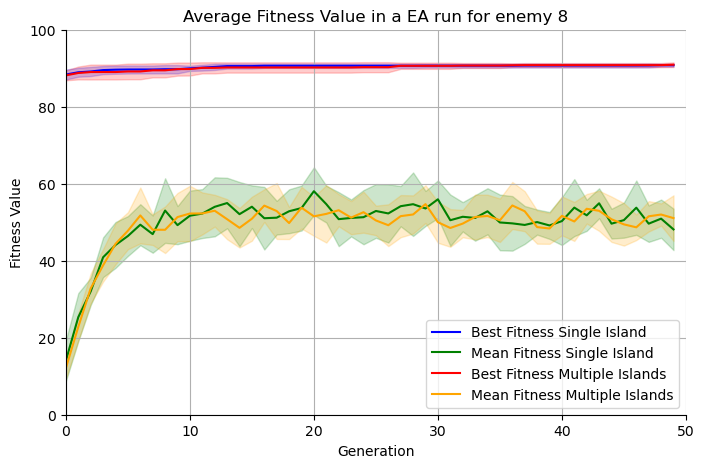

In [40]:
import matplotlib.pyplot as plt
# Define function to plot data with mean and standard deviation as filled area
def plot_with_std(ax, iterations, mean, std, label, color):
    ax.plot(iterations, mean, label=label, color=color)
    ax.fill_between(iterations, mean - std, mean + std, color=color, alpha=0.2)

# Step 1: Extract data for plotting from Group A and Group B results
iterations_a = result_a['iteration']
best_fitness_mean_a = result_a['best_fitness_mean']
mean_fitness_mean_a = result_a['mean_fitness_mean']
best_fitness_std_a = result_a['best_fitness_std']
mean_fitness_std_a = result_a['mean_fitness_std']

iterations_b = result_b['iteration']
best_fitness_mean_b = result_b['best_fitness_mean']
mean_fitness_mean_b = result_b['mean_fitness_mean']
best_fitness_std_b = result_b['best_fitness_std']
mean_fitness_std_b = result_b['mean_fitness_std']

# Step 2: Plotting the data
fig, ax = plt.subplots(figsize=(8, 5))

# Plot for Group A
plot_with_std(ax, iterations_a, best_fitness_mean_a, best_fitness_std_a, label="Best Fitness Single Island", color='blue')
plot_with_std(ax, iterations_a, mean_fitness_mean_a, mean_fitness_std_a, label="Mean Fitness Single Island", color='green')

# Plot for Group B
plot_with_std(ax, iterations_b, best_fitness_mean_b, best_fitness_std_b, label="Best Fitness Multiple Islands", color='red')
plot_with_std(ax, iterations_b, mean_fitness_mean_b, mean_fitness_std_b, label="Mean Fitness Multiple Islands", color='orange')

# Step 3: Configure the plot
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Value')
ax.set_title(f'Average Fitness Value in a EA run for enemy {enemy_number}')
ax.set_ylim(0, 100)
ax.set_xlim(result_a['iteration'].min(), result_a['iteration'].max())
ax.set_xticks(range(result_a['iteration'].min(), result_a['iteration'].max() + 10, 10))
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)

# Display the plot
plt.show()